# HuBMAP + HPA 1024x1024 png dataset
This notebook produces a downsized HuBMAP + HPA competition dataset of 1024x1024 images. Both the training images and their respective masks are produced and saved in png format.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [2]:
INPUT_PATH = '/kaggle/input/hubmap-organ-segmentation'
OUTPUT_PATH = '/kaggle/working/HuBMAP-HPA-1024x1024-PNG'
RESOLUTION = 1024
train_images_path = os.path.join(INPUT_PATH, 'train_images')

In [3]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
df.sample(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
152,23880,kidney,HPA,3000,3000,0.4,4,862386 53 865383 60 868382 63 871379 68 874301...,59.0,Male
315,737,prostate,HPA,3000,3000,0.4,4,2970903 20 2973901 24 2976888 43 2979884 48 29...,55.0,Male


Helper functions for converting the RLEncoding to an array and for loading and resizing the images

In [4]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
def get_image_mask(image_id, new_size=None):
    image = cv2.imread(os.path.join(train_images_path, f"{image_id}.tiff"), cv2.IMREAD_UNCHANGED)
    mask = rle2mask(
        df[df.id == image_id]["rle"].values[0], 
        (image.shape[1], image.shape[0]))
    if new_size:
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_AREA)

    return image, mask

In [6]:
# A sample image for testing the helper functions
im_id = 10044
img, mask = get_image_mask(im_id)
print(img.shape, mask.shape, img.mean(axis=(0,1)), img.std(axis=(0,1)))
img_d, mask_d = get_image_mask(im_id, new_size=(RESOLUTION, RESOLUTION))
print(img_d.shape, mask_d.shape, img_d.mean(axis=(0,1)), img_d.std(axis=(0,1)))

(3000, 3000, 3) (3000, 3000) [223.68097078 216.88950744 221.50935878] [32.91643836 40.04559315 34.64985881]
(1024, 1024, 3) (1024, 1024) [223.67170715 216.87902832 221.49855518] [32.90909984 40.03339197 34.64926157]


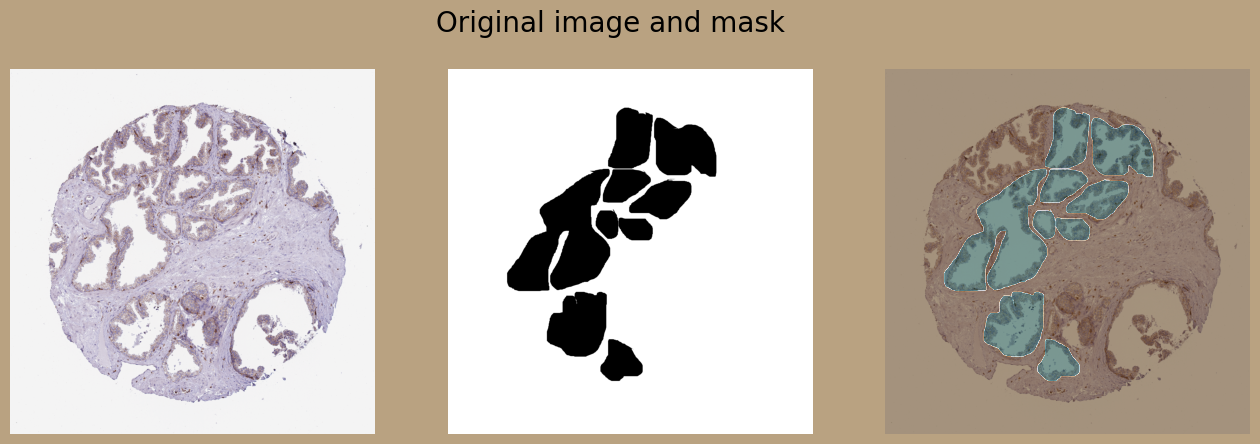

In [7]:
def display_sample(image, mask):
    fig = plt.figure(figsize=(16, 5))
    fig.suptitle('Original image and mask', fontsize=20)
    fig.patch.set_facecolor('xkcd:taupe')
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    ax = plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="binary")
    plt.axis("off")
    ax = plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap="BrBG", alpha=0.5)
    plt.axis("off")
    
RGBimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display_sample(RGBimg, mask)

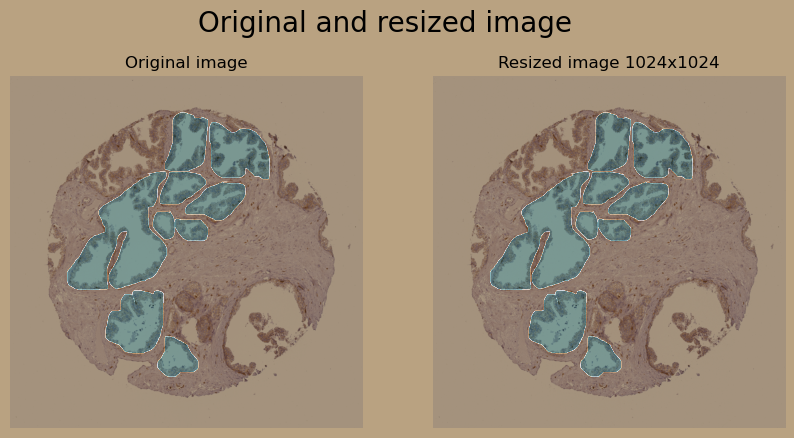

In [8]:
# Display the two images side by side with their respective masks  
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Original and resized image', fontsize=20)
fig.patch.set_facecolor('xkcd:taupe')
ax = plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(mask, cmap="BrBG", alpha=0.5)
plt.axis("off")
ax = plt.subplot(1, 2, 2)
plt.title("Resized image 1024x1024")
plt.imshow(cv2.cvtColor(img_d, cv2.COLOR_BGR2RGB))
plt.imshow(mask_d, cmap="BrBG", alpha=0.5)
plt.axis("off")
plt.show()

## Create the dataset with resolution 1024x1024

While loading every picture and resizing it, we will also calculate the mean value and standard deviation of evey channel (RGB) of all the images in the dataset.  
There is a very detailed article of how this should be done properly by Nikita Kozodoi in this article: [Computing Mean & STD in Image Dataset](https://kozodoi.me/blog/20210308/compute-image-stats)

In [9]:
train_dir = os.path.join(OUTPUT_PATH, "train") 
mask_dir = os.path.join(OUTPUT_PATH, "masks")
try: 
    os.makedirs(train_dir)
except OSError as error: 
    print(error)  

try: 
    os.makedirs(mask_dir)
except OSError as error: 
    print(error)  

In [10]:
pixels = 0.0
psum = np.zeros(3).astype(float)
psum_sq = np.zeros(3).astype(float)

for im_id in tqdm(df.id, file=sys.stdout, colour="blue"):
    img, mask = get_image_mask(im_id, new_size=(RESOLUTION, RESOLUTION))
    pixels += img.shape[0]*img.shape[1]
    psum += np.sum(img.astype(float), axis=(0,1))
    psum_sq += np.power(img.astype(float), 2).sum(axis=(0,1))
    # Save image and mask
    cv2.imwrite(os.path.join(train_dir, f"{im_id}.png"), img)
    cv2.imwrite(os.path.join(mask_dir, f"{im_id}.png"), img)
           
total_mean = psum/pixels
total_std = np.sqrt((psum_sq/pixels) - total_mean**2)
# transpose from BGR to RGB
temp = total_mean[2]; total_mean[2] = total_mean[0]; total_mean[0] = temp;
temp = total_std[2]; total_std[2] = total_std[0]; total_std[0] = temp;
print(f"Total mean of dataset: {total_mean}")
print(f"Total std of dataset: {total_std}")

100%|██████████| 351/351 [04:16<00:00,  1.37it/s]
Total mean of dataset: [211.20151643 204.67735042 209.23892375]
Total std of dataset: [43.26604051 50.07292728 47.15776597]


In [11]:
!ls -l /kaggle/working/HuBMAP-HPA-1024x1024-PNG/train | grep png | wc -l
!ls -l /kaggle/working/HuBMAP-HPA-1024x1024-PNG/masks | grep png | wc -l
# Should show 351 files twice

351
351
